In [62]:
import pandas as pd

data = pd.read_csv("../new_csv/data_with_agents_split.csv")
data.head()

,GameRulesetName,Id,agent1,agent2,utility_agent1,utility_agent2,Stochastic,HiddenInformation,Match,Asymmetric,...,NumStartComponentsBoardPerPlayer,NumStartComponentsHandPerPlayer,NumStartComponentsPerPlayer,IsPieceAt,SolvedEnd,SkillTrace,SkillTraceScore,SkillTraceTrials,SkillTraceErrorSlope,SkillTraceErrorIntercept
0,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# Investigate the presence of the Random agent

no_randoms = ((data["agent1"] == "'Random'") | (data["agent2"] == "'Random'")).sum()
print(f"{no_randoms} out of the {data.shape[0]} match-ups are with a Random agent")

# Pretty much half of our match-ups involve a Random agent

134053 out of the 266309 match-ups are with a Random agent


In [64]:
# Investigate whether agents can play themselves

agents = data["agent1"].unique()
agents.sort()

for a in agents:
    if ((data["agent1"] == a) & (data["agent2"] == a)).any():
        print("Bingo")
        break

Bingo


In [65]:
# We should remove the match-ups in which both agents are the same
# After all, we are not interested in predicting the winner of "a vs a"

mod_data = data.copy()

for a in agents:
    indices = mod_data[(mod_data["agent1"] == a) & (mod_data["agent2"] == a)].index
    mod_data = mod_data.drop(index=indices)
    
    print(f"{a}: {len(indices)} match-ups")

print(f"Total: {data.shape[0] - mod_data.shape[0]} match-ups")

'MCTS-ProgressiveHistory-0.1-MAST': 65 match-ups
'MCTS-ProgressiveHistory-0.1-NST': 120 match-ups
'MCTS-ProgressiveHistory-0.1-Random0': 40 match-ups
'MCTS-ProgressiveHistory-0.1-Random200': 34 match-ups
'MCTS-ProgressiveHistory-0.1-Random4': 48 match-ups
'MCTS-ProgressiveHistory-0.6-MAST': 63 match-ups
'MCTS-ProgressiveHistory-0.6-NST': 35 match-ups
'MCTS-ProgressiveHistory-0.6-Random0': 20 match-ups
'MCTS-ProgressiveHistory-0.6-Random200': 60 match-ups
'MCTS-ProgressiveHistory-0.6-Random4': 7 match-ups
'MCTS-ProgressiveHistory-1.41421356237-MAST': 40 match-ups
'MCTS-ProgressiveHistory-1.41421356237-NST': 40 match-ups
'MCTS-ProgressiveHistory-1.41421356237-Random0': 0 match-ups
'MCTS-ProgressiveHistory-1.41421356237-Random200': 0 match-ups
'MCTS-ProgressiveHistory-1.41421356237-Random4': 20 match-ups
'MCTS-UCB1-0.1-MAST': 0 match-ups
'MCTS-UCB1-0.1-NST': 60 match-ups
'MCTS-UCB1-0.1-Random0': 18 match-ups
'MCTS-UCB1-0.1-Random200': 60 match-ups
'MCTS-UCB1-0.1-Random4': 66 match-ups
'MC

In [66]:
# Investigate the utility values

mod_data["utility_agent1"].value_counts()

utility_agent1
 1.000000    114736
-1.000000    103649
 0.000000     30981
-0.333333      2681
 0.333333      1797
-0.200000      1003
 0.666667       402
-0.666667       292
 0.500000       214
-0.500000       180
-0.428571        74
 0.714286        73
-0.714286        72
-0.142857        72
 0.142857        69
 0.428571        65
-0.833333        58
-0.166667        47
-0.750000        45
 0.166667        33
 0.600000        20
-0.066667        18
 0.733333        18
 0.866667        16
-0.200000        16
 0.466667        15
-0.866667        15
-0.600000        15
-0.733333        13
 0.833333        13
 0.066667        11
 0.200000        10
-0.466667         9
 0.571429         7
 0.285714         6
-0.250000         6
-0.571429         5
 0.250000         4
-0.933333         3
-0.285714         3
-0.857143         3
 0.750000         1
Name: count, dtype: int64

In [67]:
mod_data[["utility_agent1", "utility_agent2"]].drop_duplicates()

,utility_agent1,utility_agent2
0,1.000000,-1.000000
11,0.000000,0.000000
12,-1.000000,1.000000
49911,-0.333333,1.000000
49912,1.000000,-0.333333
...,...,...
237261,1.000000,-0.833333
237448,0.833333,0.000000
237544,0.500000,-0.666667
237948,-0.200000,-0.200000


In [68]:
# It seems we don't always have a [1, -1] (winner, loser), [-1, 1] (loser, winner) or [0, 0] (draw)
# Let's define the utility of an agent as whether they were better than their opponent
# Then:
# - utility_agent1 == utility_agent2 -> draw [0, 0]
# - utility_agent1 > utility_agent2 -> agent 1 wins; agent 2 loses [1, -1]
# - utility_agent1 < utility_agent2 -> agent 1 loses; agent 2 wins [-1, 1]

def modify_utilities(utilities):
    mod_utilities = utilities.copy()
    
    if utilities.iloc[0] == utilities.iloc[1]:
        mod_utilities.iloc[0] = 0
        mod_utilities.iloc[1] = 0
    elif utilities.iloc[0] > utilities.iloc[1]:
        mod_utilities.iloc[0] = 1
        mod_utilities.iloc[1] = -1
    else:
        mod_utilities.iloc[0] = -1
        mod_utilities.iloc[1] = 1
    
    return mod_utilities

mod_data[["utility_agent1", "utility_agent2"]] = mod_data[["utility_agent1", "utility_agent2"]].apply(lambda utilities: modify_utilities(utilities), axis=1)

In [69]:
# Generate data on match-ups between agents

no_agents = len(agents)
matchup_data = {
    "Agent 1": [],
    "Agent 2": [],
    "No matches": [],
    "No draws": [],
    "No wins by 1": [],
    "No wins by 2": [],
    "No games": []
}

for i in range(no_agents):
    for j in range(no_agents):
        if i == j:
            continue
        
        matchup_data["Agent 1"].append(agents[i])
        matchup_data["Agent 2"].append(agents[j])
        
        matches = mod_data[(mod_data["agent1"] == agents[i]) & (mod_data["agent2"] == agents[j])]
        
        no_matches = matches.shape[0]
        matchup_data["No matches"].append(no_matches)
        
        if no_matches == 0:
            for col in ["No draws", "No wins by 1", "No wins by 2", "No games"]:
                matchup_data[col].append(0)
            continue
        
        no_draws = (matches["utility_agent1"] == matches["utility_agent2"]).sum()
        matchup_data["No draws"].append(no_draws)

        no_wins_by_1 = (matches["utility_agent1"] > matches["utility_agent2"]).sum()
        matchup_data["No wins by 1"].append(no_wins_by_1)

        no_wins_by_2 = (matches["utility_agent2"] > matches["utility_agent1"]).sum()
        matchup_data["No wins by 2"].append(no_wins_by_2)
        
        no_games = matches["Id"].nunique()
        matchup_data["No games"].append(no_games)

matchup_data = pd.DataFrame.from_dict(matchup_data)
matchup_data

,Agent 1,Agent 2,No matches,No draws,No wins by 1,No wins by 2,No games
0,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',43,0,26,17,5
1,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random0',16,6,0,10,2
2,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random200',62,1,22,39,7
3,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random4',50,24,13,13,6
4,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.6-MAST',54,11,8,35,7
...,...,...,...,...,...,...,...
3655,'Random','MCTS-UCB1Tuned-1.41421356237-MAST',963,92,53,818,95
3656,'Random','MCTS-UCB1Tuned-1.41421356237-NST',1151,96,71,984,113
3657,'Random','MCTS-UCB1Tuned-1.41421356237-Random0',1062,107,130,825,104
3658,'Random','MCTS-UCB1Tuned-1.41421356237-Random200',1155,77,53,1025,115


In [70]:
# Investigate generated data

matchless = matchup_data[matchup_data["No matches"] == 0]
matchless

,Agent 1,Agent 2,No matches,No draws,No wins by 1,No wins by 2,No games
251,'MCTS-ProgressiveHistory-0.1-Random4','MCTS-ProgressiveHistory-1.41421356237-Random0',0,0,0,0,0
254,'MCTS-ProgressiveHistory-0.1-Random4','MCTS-UCB1-0.1-MAST',0,0,0,0,0
313,'MCTS-ProgressiveHistory-0.6-MAST','MCTS-ProgressiveHistory-1.41421356237-Random4',0,0,0,0,0
402,'MCTS-ProgressiveHistory-0.6-NST','MCTS-UCB1GRAVE-1.41421356237-Random200',0,0,0,0,0
439,'MCTS-ProgressiveHistory-0.6-Random0','MCTS-UCB1-0.6-MAST',0,0,0,0,0
519,'MCTS-ProgressiveHistory-0.6-Random200','MCTS-UCB1GRAVE-1.41421356237-MAST',0,0,0,0,0
525,'MCTS-ProgressiveHistory-0.6-Random200','MCTS-UCB1Tuned-0.1-NST',0,0,0,0,0
549,'MCTS-ProgressiveHistory-0.6-Random4','MCTS-ProgressiveHistory-1.41421356237-MAST',0,0,0,0,0
609,'MCTS-ProgressiveHistory-1.41421356237-MAST','MCTS-ProgressiveHistory-0.6-Random4',0,0,0,0,0
724,'MCTS-ProgressiveHistory-1.41421356237-Random0','MCTS-ProgressiveHistory-0.1-Random4',0,0,0,0,0


In [71]:
# It seems that not all match-ups are covered by the data -> let's remove them

def get_indices(matchup):
    m_idx = matchup_data[(matchup_data["Agent 1"] == matchup.iloc[0]) & (matchup_data["Agent 2"] == matchup.iloc[1])].index[0]
    if m_idx in indices:
        return 
    indices.append(m_idx)
    
    # Let's ensure the reverse of this match-up also gets removed (even if it is present in the data!)
    r_idx = matchup_data[(matchup_data["Agent 1"] == matchup.iloc[1]) & (matchup_data["Agent 2"] == matchup.iloc[0])].index[0]
    indices.append(r_idx)

indices = []
matchless[["Agent 1", "Agent 2"]].apply(lambda matchup: get_indices(matchup), axis=1)
matchup_data = matchup_data.drop(index=indices)

In [72]:
# Generate win percentage columns
matchup_data["Win percentage of 1"] = matchup_data["No wins by 1"] / matchup_data["No matches"] * 100
matchup_data["Win percentage of 2"] = matchup_data["No wins by 2"] / matchup_data["No matches"] * 100

# Remove match-ups involving a Random agent
matchup_data = matchup_data[(matchup_data["Agent 1"] != "'Random'") & (matchup_data["Agent 2"] != "'Random'")]

matchup_data

,Agent 1,Agent 2,No matches,No draws,No wins by 1,No wins by 2,No games,Win percentage of 1,Win percentage of 2
0,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',43,0,26,17,5,60.465116,39.534884
1,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random0',16,6,0,10,2,0.000000,62.500000
2,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random200',62,1,22,39,7,35.483871,62.903226
3,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-Random4',50,24,13,13,6,26.000000,26.000000
4,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.6-MAST',54,11,8,35,7,14.814815,64.814815
...,...,...,...,...,...,...,...,...,...
3594,'MCTS-UCB1Tuned-1.41421356237-Random4','MCTS-UCB1Tuned-0.6-Random4',31,1,16,14,4,51.612903,45.161290
3595,'MCTS-UCB1Tuned-1.41421356237-Random4','MCTS-UCB1Tuned-1.41421356237-MAST',23,0,9,14,3,39.130435,60.869565
3596,'MCTS-UCB1Tuned-1.41421356237-Random4','MCTS-UCB1Tuned-1.41421356237-NST',50,0,5,45,5,10.000000,90.000000
3597,'MCTS-UCB1Tuned-1.41421356237-Random4','MCTS-UCB1Tuned-1.41421356237-Random0',29,12,9,8,4,31.034483,27.586207


In [73]:
# Generate descriptives on match-ups

matchup_data.describe()

,No matches,No draws,No wins by 1,No wins by 2,No games,Win percentage of 1,Win percentage of 2
count,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000
mean,37.118436,5.887557,16.559932,14.670947,4.494578,44.444644,39.085954
std,18.004788,6.185534,11.671342,11.113532,2.034101,23.805176,23.467967
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,23.000000,0.000000,8.000000,6.000000,3.000000,27.272727,21.428571
50%,35.000000,4.000000,14.000000,13.000000,4.000000,43.920916,37.931034
75%,50.000000,10.000000,23.000000,21.000000,6.000000,60.546252,54.545455
max,102.000000,38.000000,78.000000,70.000000,13.000000,100.000000,100.000000


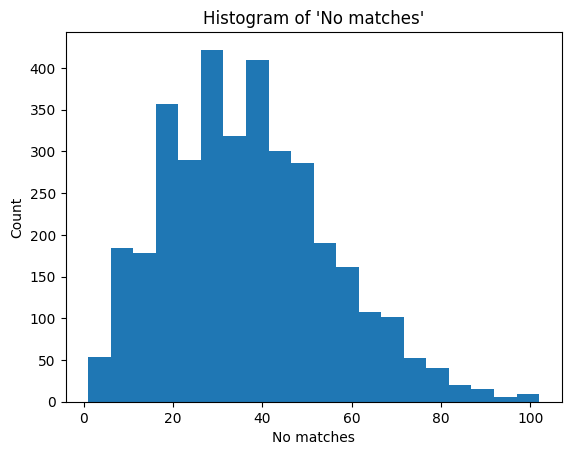

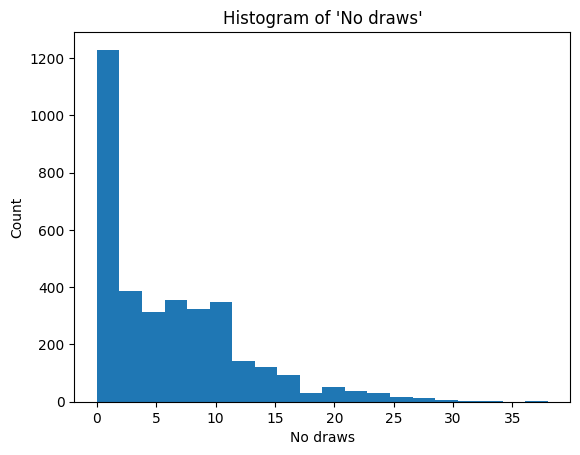

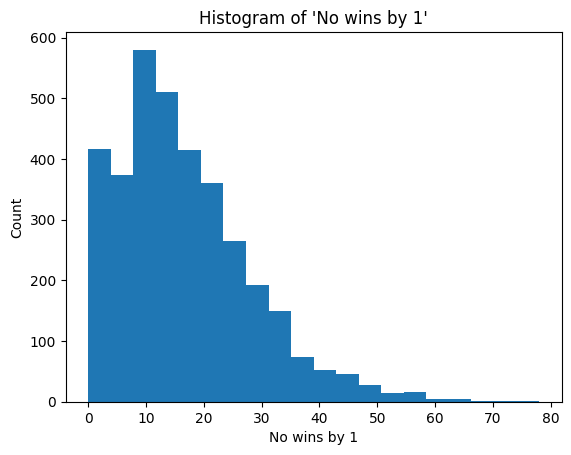

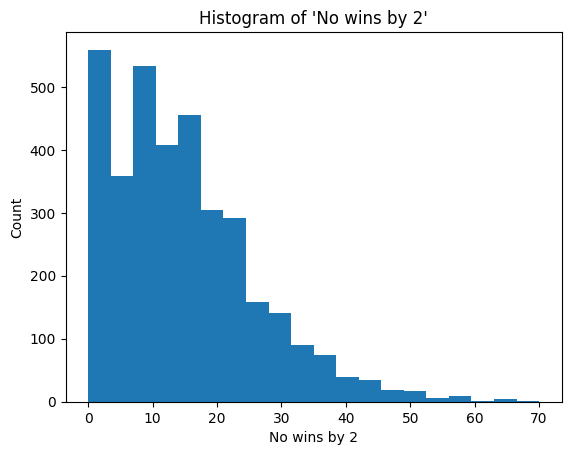

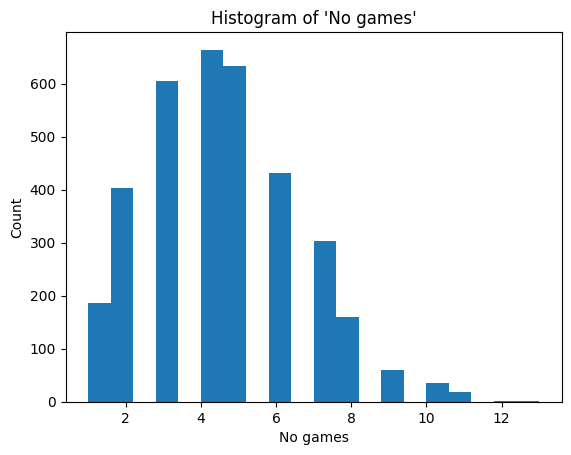

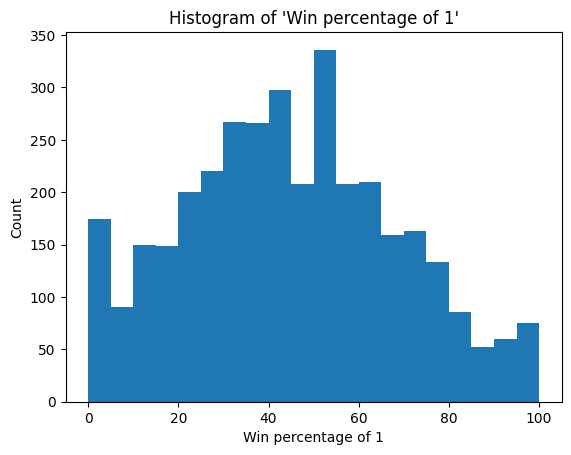

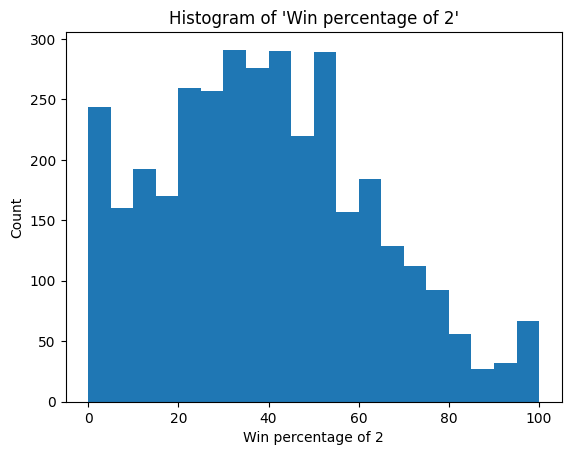

In [74]:
# Generate histograms on match-ups

from matplotlib import pyplot as plt

def generate_histogram(column):
    plt.hist(matchup_data[column], bins=20)
    plt.title(f"Histogram of '{column}'")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

for col in matchup_data.columns:
    if col in ["Agent 1", "Agent 2"]:
        continue
    
    generate_histogram(col)

In [75]:
# Let's do some filtering on our matches data

def get_legal_matchups():
    matchups = []
    matchup_data[["Agent 1", "Agent 2"]].apply(lambda m: matchups.append((m.iloc[0], m.iloc[1])), axis=1)
    return matchups

legal_matchups = get_legal_matchups()
f = mod_data[["agent1", "agent2"]].apply(lambda m: (m.iloc[0], m.iloc[1]) in legal_matchups, axis=1)
mod_data = mod_data[f]

In [76]:
# ML brainstorm:
# - First idea:
#       * When tasked with answering the question "Which of the agents A and B performs better?", we restrict ourselves to the portion of the data that describes matches between A and B.
#       * We need to compress the matches from the same game into one instance:
#           > Features: values of concepts (ruleset)
#           > Label: A / B / Draw
#       * We can start easy with a Decision Tree, which does feature selection for us.
#       * Potential problems:
#           > Not enough instances per match-up
#           > Imbalanced dataset may yield a poor Decision Tree classifier

# Generate ML data
A = legal_matchups[0][0]
B = legal_matchups[0][1]

matches_AB = mod_data[(mod_data["agent1"] == A) & (mod_data["agent2"] == B)]
matches_BA = mod_data[(mod_data["agent1"] == B) & (mod_data["agent2"] == A)]

In [77]:
matches_AB

,GameRulesetName,Id,agent1,agent2,utility_agent1,utility_agent2,Stochastic,HiddenInformation,Match,Asymmetric,...,NumStartComponentsBoardPerPlayer,NumStartComponentsHandPerPlayer,NumStartComponentsPerPlayer,IsPieceAt,SolvedEnd,SkillTrace,SkillTraceScore,SkillTraceTrials,SkillTraceErrorSlope,SkillTraceErrorIntercept
56250,Paumecary,814,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56251,Paumecary,814,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56252,Paumecary,814,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56253,Paumecary,814,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56254,Paumecary,814,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56255,Paumecary,814,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56256,Paumecary,814,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',-1.0,1.0,1.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56257,Paumecary,814,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56258,Paumecary,814,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56259,Paumecary,814,'MCTS-ProgressiveHistory-0.1-MAST','MCTS-ProgressiveHistory-0.1-NST',-1.0,1.0,1.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
matches_BA

,GameRulesetName,Id,agent1,agent2,utility_agent1,utility_agent2,Stochastic,HiddenInformation,Match,Asymmetric,...,NumStartComponentsBoardPerPlayer,NumStartComponentsHandPerPlayer,NumStartComponentsPerPlayer,IsPieceAt,SolvedEnd,SkillTrace,SkillTraceScore,SkillTraceTrials,SkillTraceErrorSlope,SkillTraceErrorIntercept
56260,Paumecary,814,'MCTS-ProgressiveHistory-0.1-NST','MCTS-ProgressiveHistory-0.1-MAST',-1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56261,Paumecary,814,'MCTS-ProgressiveHistory-0.1-NST','MCTS-ProgressiveHistory-0.1-MAST',-1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56262,Paumecary,814,'MCTS-ProgressiveHistory-0.1-NST','MCTS-ProgressiveHistory-0.1-MAST',-1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56263,Paumecary,814,'MCTS-ProgressiveHistory-0.1-NST','MCTS-ProgressiveHistory-0.1-MAST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56264,Paumecary,814,'MCTS-ProgressiveHistory-0.1-NST','MCTS-ProgressiveHistory-0.1-MAST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56265,Paumecary,814,'MCTS-ProgressiveHistory-0.1-NST','MCTS-ProgressiveHistory-0.1-MAST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56266,Paumecary,814,'MCTS-ProgressiveHistory-0.1-NST','MCTS-ProgressiveHistory-0.1-MAST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56267,Paumecary,814,'MCTS-ProgressiveHistory-0.1-NST','MCTS-ProgressiveHistory-0.1-MAST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56268,Paumecary,814,'MCTS-ProgressiveHistory-0.1-NST','MCTS-ProgressiveHistory-0.1-MAST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56269,Paumecary,814,'MCTS-ProgressiveHistory-0.1-NST','MCTS-ProgressiveHistory-0.1-MAST',1.0,-1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
matches_AB["GameRulesetName"].unique()

array(['Paumecary', 'SenetKendall_Trap_Scholarly',
       'SetichchSetichch_Described',
       'Aw-li_On-nam_Ot-tjinFour_Counters_Observed',
       'AchiMurray_Described'], dtype=object)

In [80]:
matches_BA["GameRulesetName"].unique()

array(['Paumecary', 'SenetKendall_Trap_Scholarly',
       'Aw-li_On-nam_Ot-tjinFour_Counters_Observed',
       'AchiMurray_Described'], dtype=object)

In [81]:
(mod_data["TwoPlayer"] == 0).sum()

11585

In [82]:
mod_data.shape[0]

130063

In [83]:
mod_data[mod_data["TwoPlayer"].isna()]["GameRulesetName"].unique()

array(['Mbenga_Alignment_Game', 'Kriegspiel_Chess'], dtype=object)

In [84]:
mod_data[mod_data["TwoPlayer"].isna()]

,GameRulesetName,Id,agent1,agent2,utility_agent1,utility_agent2,Stochastic,HiddenInformation,Match,Asymmetric,...,NumStartComponentsBoardPerPlayer,NumStartComponentsHandPerPlayer,NumStartComponentsPerPlayer,IsPieceAt,SolvedEnd,SkillTrace,SkillTraceScore,SkillTraceTrials,SkillTraceErrorSlope,SkillTraceErrorIntercept
156711,Mbenga_Alignment_Game,1374,'MCTS-ProgressiveHistory-0.6-Random4','MCTS-ProgressiveHistory-0.1-MAST',0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156712,Mbenga_Alignment_Game,1374,'MCTS-ProgressiveHistory-0.6-Random4','MCTS-ProgressiveHistory-0.1-MAST',0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156713,Mbenga_Alignment_Game,1374,'MCTS-ProgressiveHistory-0.6-Random4','MCTS-ProgressiveHistory-0.1-MAST',0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156714,Mbenga_Alignment_Game,1374,'MCTS-ProgressiveHistory-0.6-Random4','MCTS-ProgressiveHistory-0.1-MAST',0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156715,Mbenga_Alignment_Game,1374,'MCTS-ProgressiveHistory-0.6-Random4','MCTS-ProgressiveHistory-0.1-MAST',0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227691,Kriegspiel_Chess,4185,'MCTS-UCB1GRAVE-0.1-Random0','MCTS-UCB1Tuned-1.41421356237-NST',0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227692,Kriegspiel_Chess,4185,'MCTS-UCB1Tuned-1.41421356237-NST','MCTS-UCB1GRAVE-0.1-Random0',0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227693,Kriegspiel_Chess,4185,'MCTS-UCB1Tuned-1.41421356237-NST','MCTS-UCB1GRAVE-0.1-Random0',0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227694,Kriegspiel_Chess,4185,'MCTS-UCB1Tuned-1.41421356237-NST','MCTS-UCB1GRAVE-0.1-Random0',-1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
all_nans = []

mod_data[mod_data.columns[6:]].apply(lambda x: all_nans.append(x.isna().all()), axis=1);

In [98]:
sum(all_nans)

176

In [ ]:
# Need to:
# 1. Remove "Mbenga_Alignment_Game" and "Kriegspiel_Chess" from data
# 2. Remove any non-two player games from data